<center>
    <a href="https://www.aus.edu/"><img src="https://i.imgur.com/pdZvnSD.png" width=200> </a>
</center>

<h1 align=center><font size = 5>Explainable AI</font>
<h1 align=center><font size = 5>Prepared by Alex Aklson, Ph.D.</font>
<h1 align=center><font size = 5>November 21, 2024</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, SGDRegressor

from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

import shap
from lime.lime_tabular import LimeTabularExplainer


pd.set_option('display.max_columns', None)

c:\Users\aleen\OneDrive\Desktop\DM_learn\DM_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model-Specific Explainability

#### Explainality in Linear Models

In [2]:
admission_data = pd.read_csv('datasets/admission_data.csv')

In [3]:
admission_data.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Chance of Admit,Accept
0,337,118,4,4.5,4.5,9.65,0.92,1
1,324,107,4,4.0,4.5,8.87,0.76,1
2,316,104,3,3.0,3.5,8.00,0.72,1
3,322,110,3,3.5,2.5,8.67,0.80,1
4,314,103,2,2.0,3.0,8.21,0.65,1


In [4]:
admission_data.shape

(500, 8)

In [5]:
admission_data['Accept'].value_counts()

Accept
1    461
0     39
Name: count, dtype: int64

In [6]:
X = admission_data.drop(columns=['Chance of Admit', 'Accept'])
y_cls = admission_data['Accept']
y_reg = admission_data['Chance of Admit']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
linear_regression_model = LinearRegression()

In [10]:
linear_regression_model.fit(X_train_scaled, y_train)

LinearRegression()

In [11]:
y_pred = linear_regression_model.predict(X_test_scaled)

In [12]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [13]:
print("Root Mean Squared Error: {}".format(rmse))
print("R-squared: {}".format(r2))

Root Mean Squared Error: 0.06189500437051662
R-squared: 0.8126654490940699


In [14]:
linear_regression_weights = linear_regression_model.coef_

<BarContainer object of 6 artists>

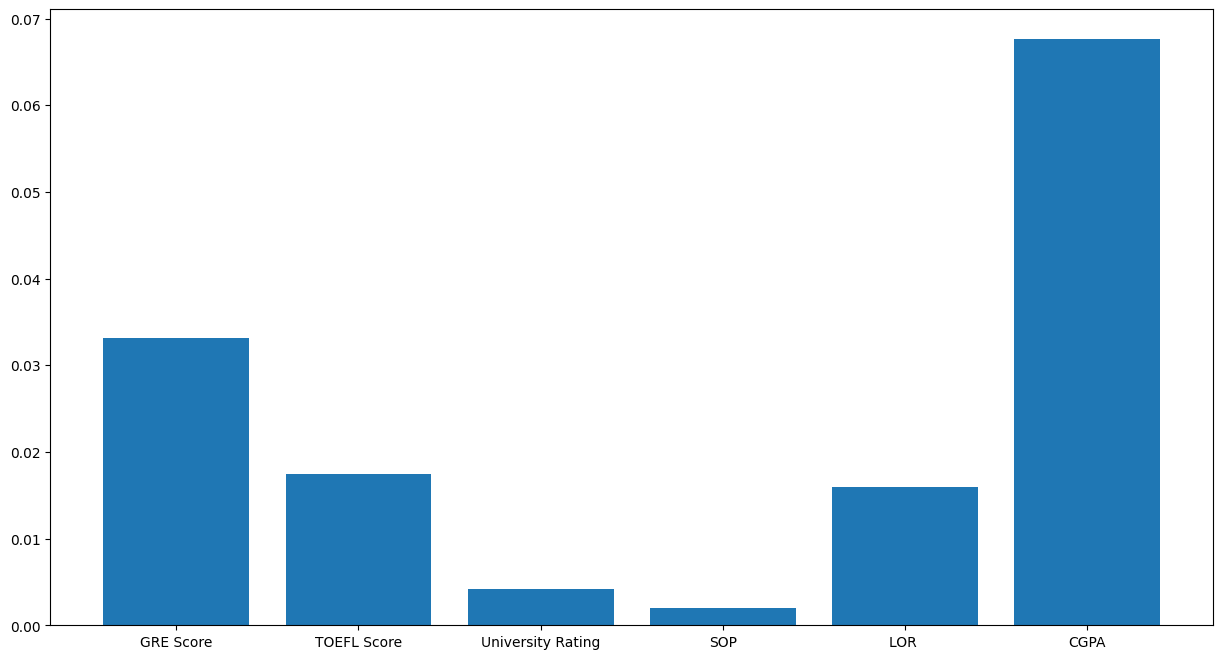

In [15]:
plt.figure(figsize=(15, 8))
plt.bar(X_train.columns, linear_regression_weights)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cls, test_size=0.2, random_state=42)

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
logistic_regression_model = LogisticRegression(penalty='l2', max_iter=10000)

In [19]:
logistic_regression_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=10000)

In [20]:
logistic_regression_weights = logistic_regression_model.coef_[0]

<BarContainer object of 6 artists>

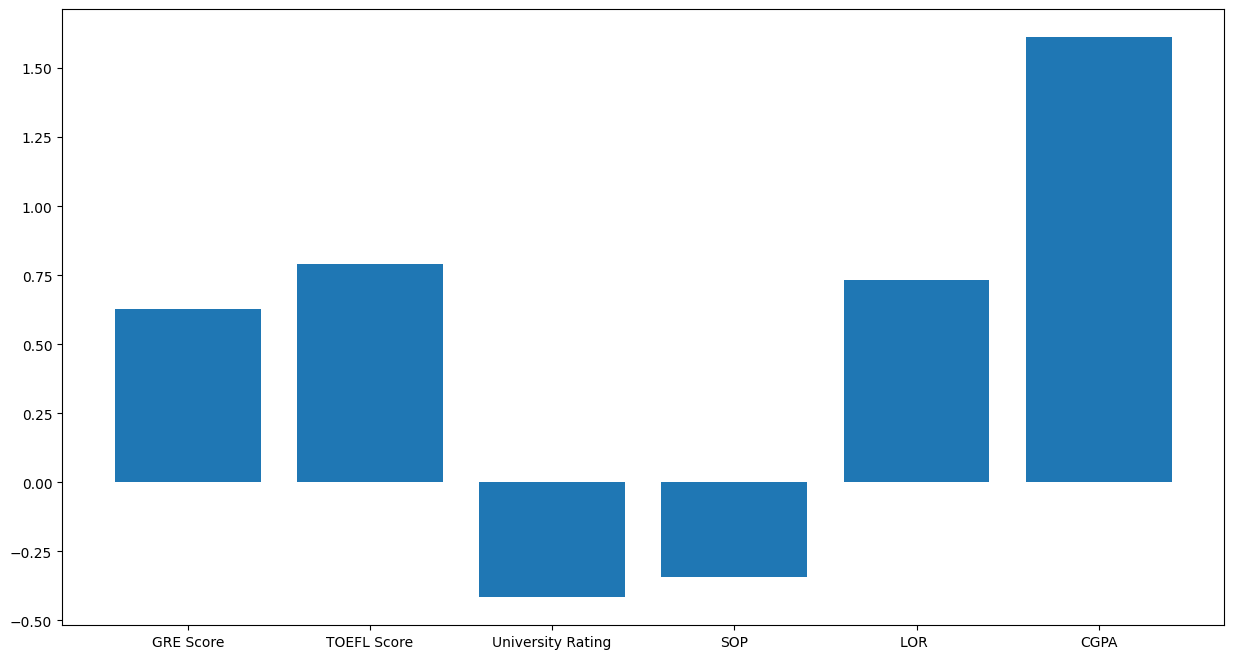

In [21]:
plt.figure(figsize=(15, 8))
plt.bar(X_train.columns, logistic_regression_weights)

#### Decision Trees and Ensembles

##### Decision Trees

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cls, test_size=0.2, random_state=42)

In [23]:
tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

rules = export_text(tree_model, feature_names=list(X_train.columns))
print(rules)

y_pred = tree_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {}'.format(accuracy))

|--- CGPA <= 8.20
|   |--- CGPA <= 7.66
|   |   |--- GRE Score <= 301.00
|   |   |   |--- class: 0
|   |   |--- GRE Score >  301.00
|   |   |   |--- class: 1
|   |--- CGPA >  7.66
|   |   |--- LOR  <= 3.25
|   |   |   |--- class: 1
|   |   |--- LOR  >  3.25
|   |   |   |--- class: 1
|--- CGPA >  8.20
|   |--- LOR  <= 2.25
|   |   |--- SOP <= 2.25
|   |   |   |--- class: 0
|   |   |--- SOP >  2.25
|   |   |   |--- class: 1
|   |--- LOR  >  2.25
|   |   |--- class: 1

Accuracy: 0.94


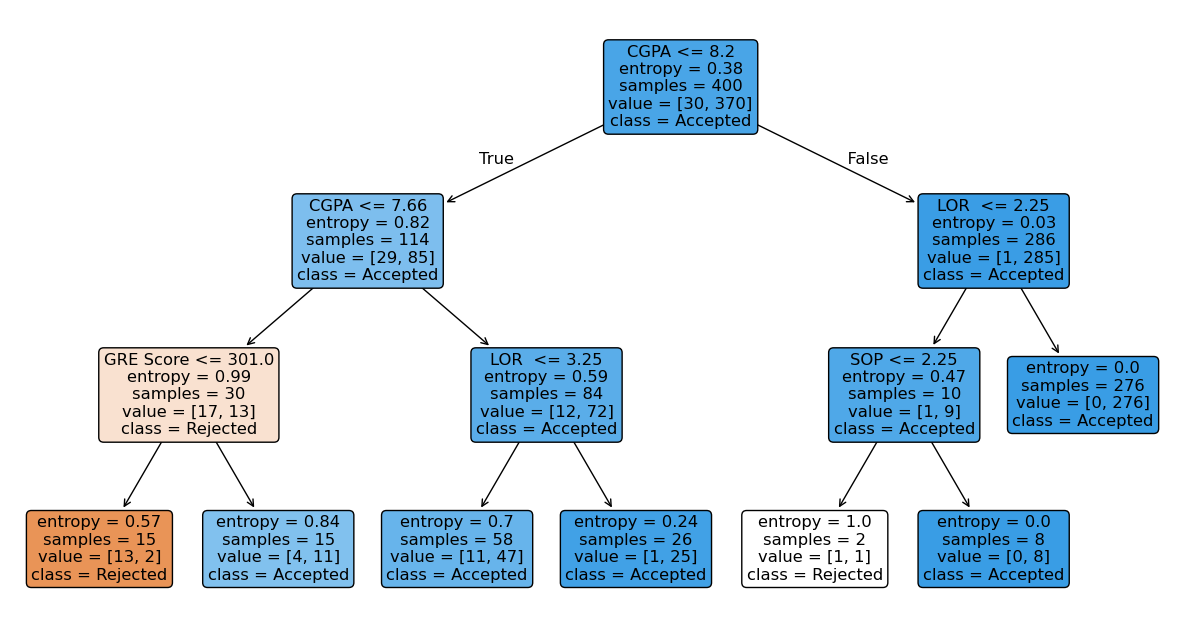

In [24]:
plt.figure(figsize=(15, 8))
plot_tree(
    tree_model,
    rounded=True,
    precision=2,
    filled=True, 
    feature_names=admission_data.columns, 
    class_names=['Rejected', 'Accepted']
)
plt.show()

In [25]:
y_pred = tree_model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.80      0.44      0.57         9
           1       0.95      0.99      0.97        91

    accuracy                           0.94       100
   macro avg       0.87      0.72      0.77       100
weighted avg       0.93      0.94      0.93       100



In [26]:
print(tree_model.feature_importances_)

[0.10208527 0.         0.         0.03205425 0.09356772 0.77229276]


<function matplotlib.pyplot.show(close=None, block=None)>

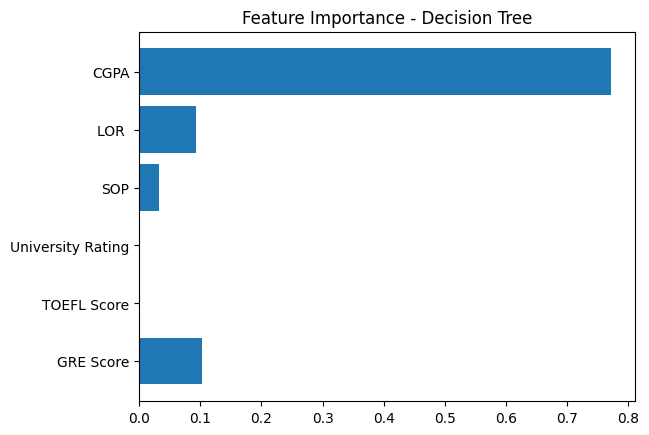

In [27]:
plt.barh(X_train.columns, tree_model.feature_importances_)
plt.title('Feature Importance - Decision Tree')
plt.show

##### Random Forests

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cls, test_size=0.2, random_state=42)

In [29]:
randomforest_model = RandomForestClassifier(random_state=42)

In [30]:
param_grid = {
    'n_estimators': [51, 101, 201],
    'max_depth': [3, 5, 10, None]
}

In [31]:
grid_search = GridSearchCV(estimator=randomforest_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 10, None],
                         'n_estimators': [51, 101, 201]},
             scoring='accuracy')

In [32]:
best_randomforest_model = grid_search.best_estimator_

In [33]:
randomforest_predictions = best_randomforest_model.predict(X_test)

In [34]:
print("Random Forest Accuracy is {}".format(accuracy_score(y_test, randomforest_predictions)))
print(classification_report(y_test, randomforest_predictions))

Random Forest Accuracy is 0.95
              precision    recall  f1-score   support

           0       1.00      0.44      0.62         9
           1       0.95      1.00      0.97        91

    accuracy                           0.95       100
   macro avg       0.97      0.72      0.79       100
weighted avg       0.95      0.95      0.94       100



In [35]:
print(best_randomforest_model.feature_importances_)

[0.23102659 0.18671167 0.04995355 0.12137703 0.10159896 0.30933221]


<function matplotlib.pyplot.show(close=None, block=None)>

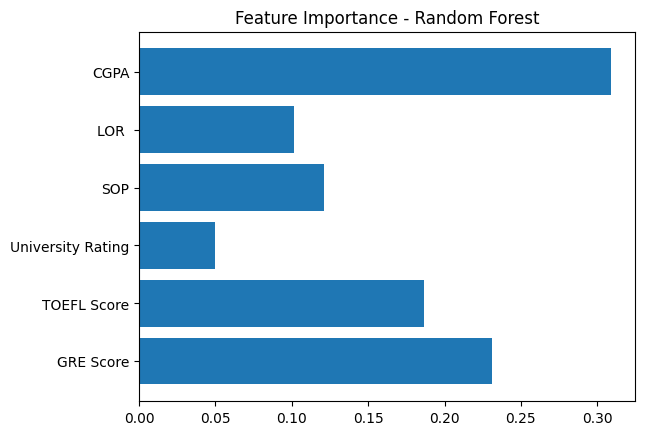

In [36]:
plt.barh(X_train.columns, best_randomforest_model.feature_importances_)
plt.title('Feature Importance - Random Forest')
plt.show

## Model-Agnostic Explainability

### Feature Permutation

In [37]:
result = permutation_importance(
    tree_model,
    X_train, y_train,
    n_repeats=10,
    scoring='accuracy',
    random_state=42,
)

<BarContainer object of 6 artists>

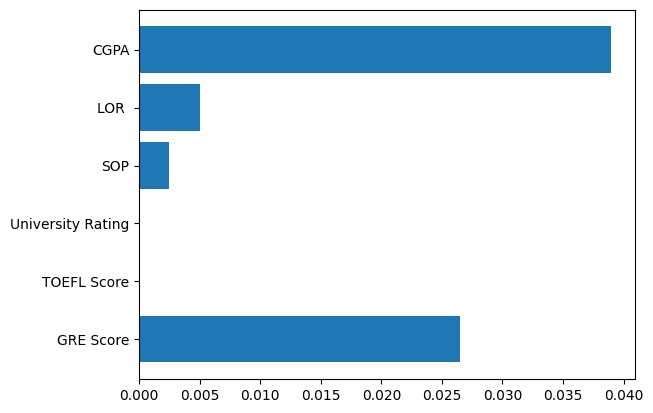

In [38]:
plt.barh(X_train.columns, result.importances_mean)

In [39]:
result = permutation_importance(
    best_randomforest_model,
    X_train, y_train,
    n_repeats=10,
    scoring='accuracy',
    random_state=42,
)

<BarContainer object of 6 artists>

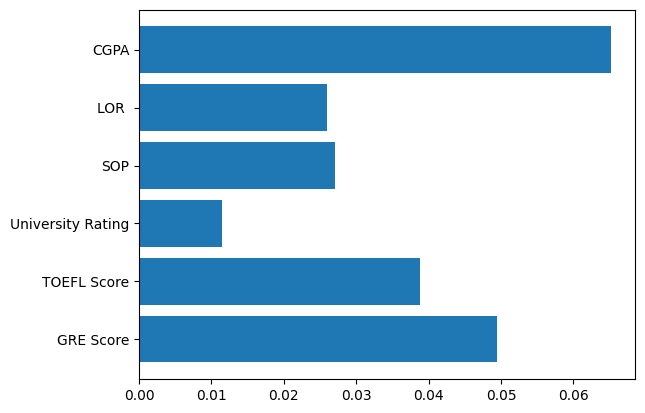

In [40]:
plt.barh(X_train.columns, result.importances_mean)

### SHAP Explainability

#### Type-Specific Explainers

##### Random Forest Regressor

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

In [42]:
rf_instance = RandomForestRegressor(random_state=42)

In [43]:
param_grid = {
    'n_estimators': [51, 101, 201],
    'max_depth': [3, 5, 10, None]
}

In [44]:
grid_search = GridSearchCV(estimator=rf_instance, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, 10, None],
                         'n_estimators': [51, 101, 201]},
             scoring='r2')

In [45]:
rf_regressor = grid_search.best_estimator_

##### Random Forest Classifier

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cls, test_size=0.2, random_state=42)

In [47]:
rf_instance = RandomForestClassifier(random_state=42)

In [48]:
param_grid = {
    'n_estimators': [51, 101, 201],
    'max_depth': [3, 5, 10, None]
}

In [49]:
grid_search = GridSearchCV(estimator=rf_instance, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 10, None],
                         'n_estimators': [51, 101, 201]},
             scoring='accuracy')

In [50]:
rf_classifier = grid_search.best_estimator_

##### Deriving SHAP values - rf_regressor

In [51]:
explainer_reg = shap.TreeExplainer(rf_regressor)

In [52]:
shap_values_reg = explainer_reg.shap_values(X_train)

In [53]:
shap_values_reg.shape

(400, 6)

In [54]:
mean_shap_values_reg = np.abs(shap_values_reg).mean(axis=0)

<BarContainer object of 6 artists>

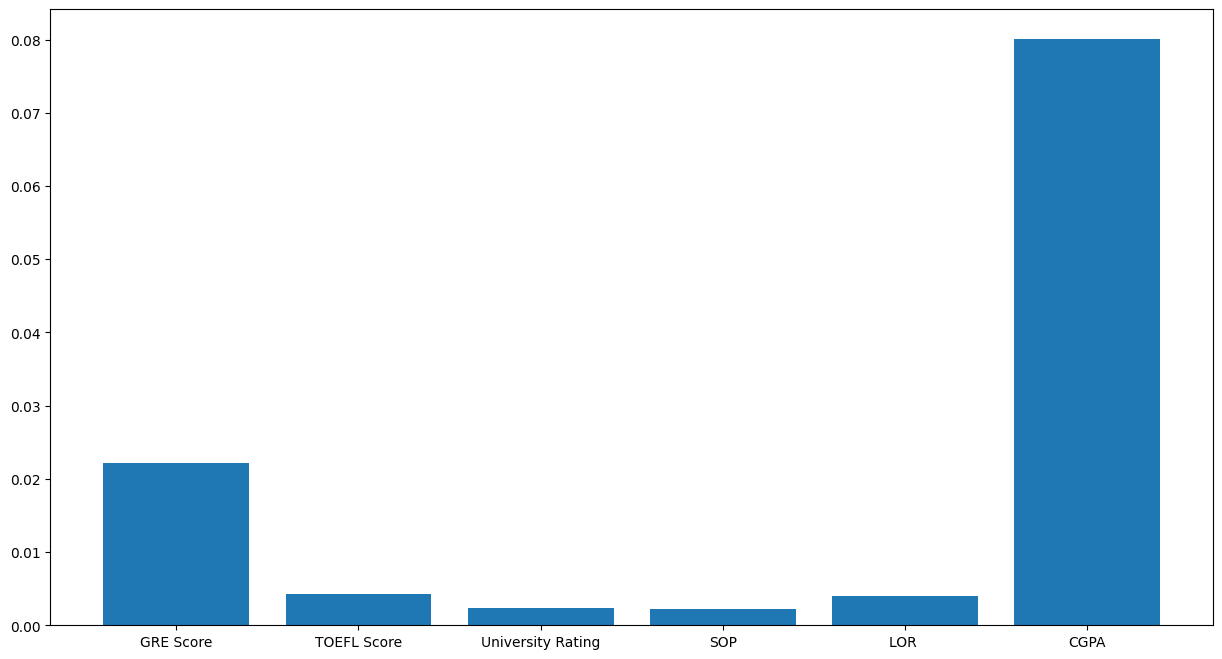

In [55]:
plt.figure(figsize=(15, 8))
plt.bar(X_train.columns, mean_shap_values_reg)

##### Deriving SHAP values - rf_classifier

In [56]:
explainer_cls = shap.TreeExplainer(rf_classifier)

In [57]:
shap_values_cls = explainer_cls.shap_values(X_train)

In [58]:
shap_values_cls.shape

(400, 6, 2)

In [59]:
mean_shap_values_reg = np.abs(shap_values_cls[:, :, 1]).mean(axis=0)

<BarContainer object of 6 artists>

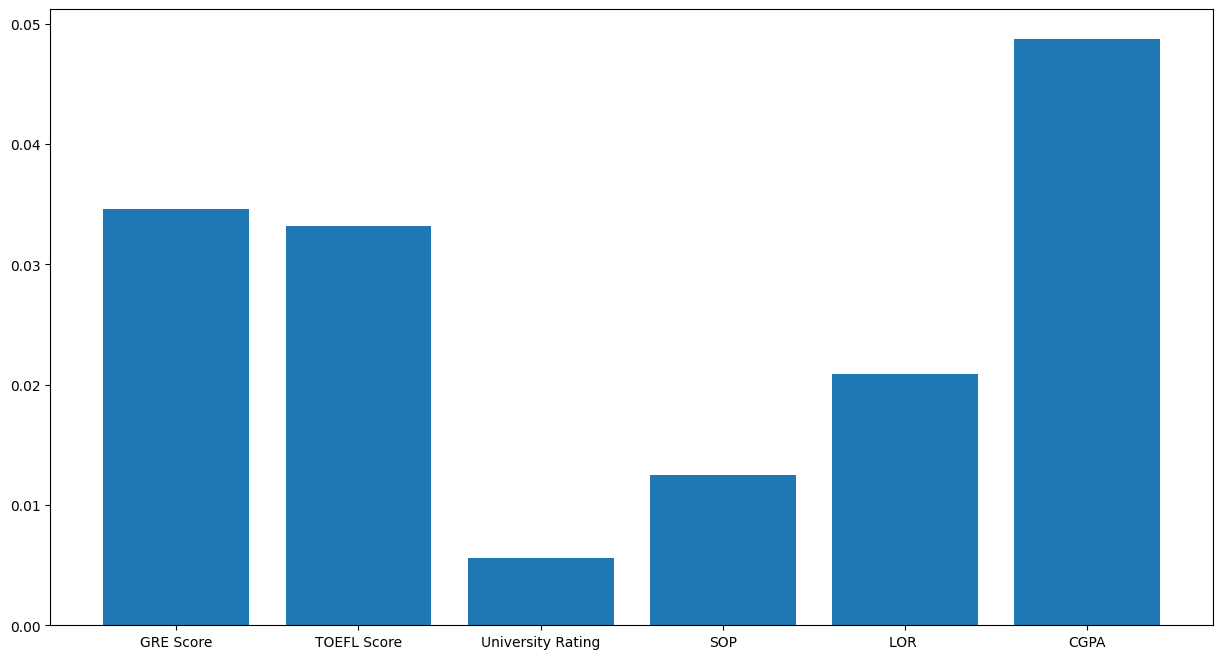

In [60]:
plt.figure(figsize=(15, 8))
plt.bar(X_train.columns, mean_shap_values_reg)

#### General Explainers (Kernel Explainers)

##### Regression

In [61]:
X_train.shape

(400, 6)

In [62]:
explainer_reg = shap.KernelExplainer(
    rf_regressor.predict,
    shap.kmeans(X_train, 10)
)

In [63]:
shap_values_reg = explainer_reg.shap_values(X_train)

100%|██████████| 400/400 [00:05<00:00, 77.63it/s]


In [64]:
mean_shap_values_reg = np.abs(shap_values_reg).mean(axis=0)

<BarContainer object of 6 artists>

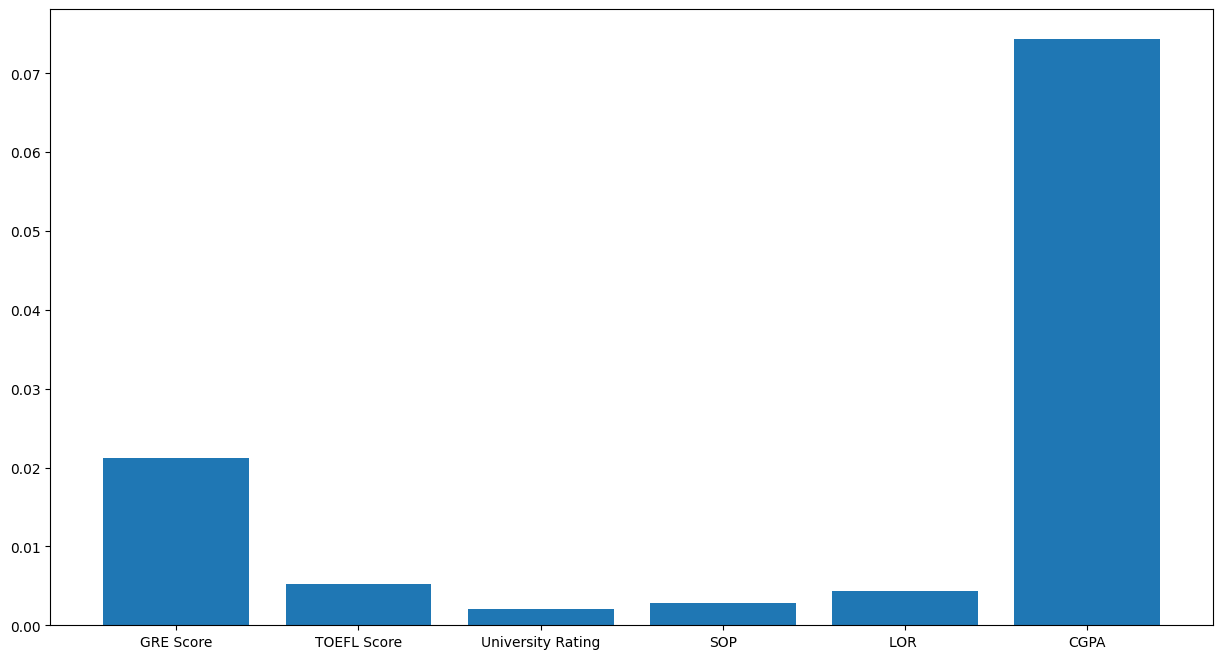

In [65]:
plt.figure(figsize=(15, 8))
plt.bar(X_train.columns, mean_shap_values_reg)

##### Classification

In [66]:
explainer_cls = shap.KernelExplainer(
    rf_classifier.predict_proba,
    shap.kmeans(X_train, 10)
)

In [67]:
shap_values_cls = explainer_cls.shap_values(X_train)

100%|██████████| 400/400 [00:03<00:00, 111.13it/s]


In [69]:
shap_values_cls.shape

(400, 6, 2)

In [ ]:
mean_shap_values_cls = np.abs(shap_values_cls[:, :, 1]).mean(axis=0)

<BarContainer object of 6 artists>

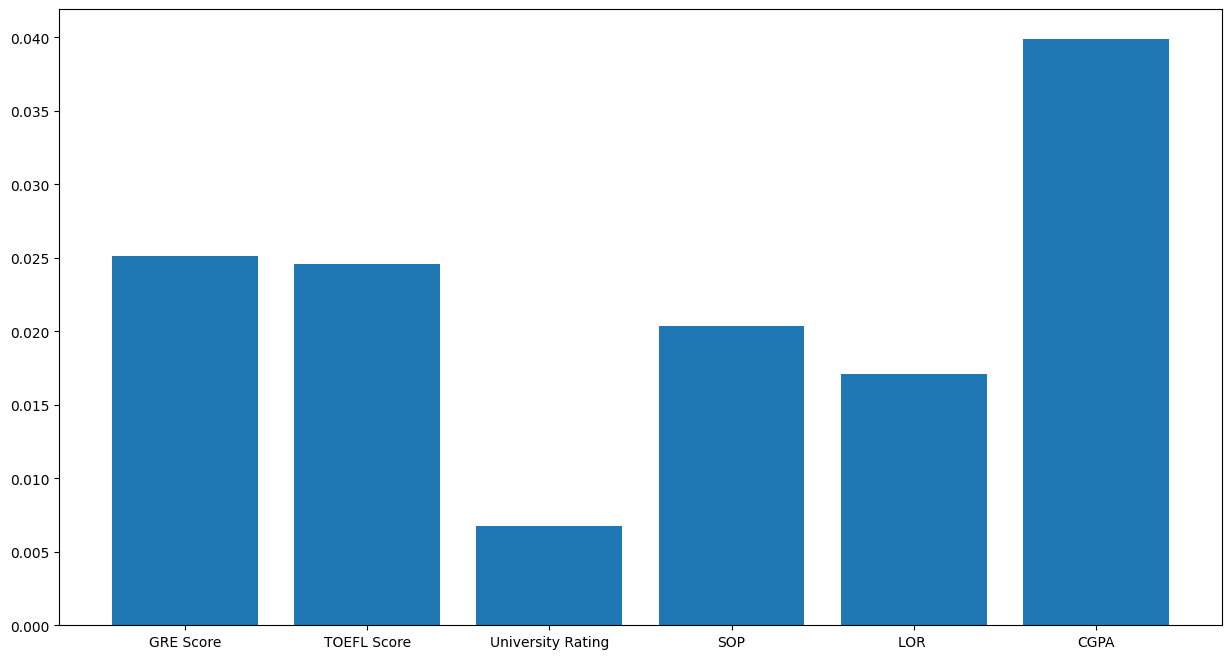

In [ ]:
plt.figure(figsize=(15, 8))
plt.bar(X_train.columns, mean_shap_values_cls)

#### Visualizing SHAP Explainability

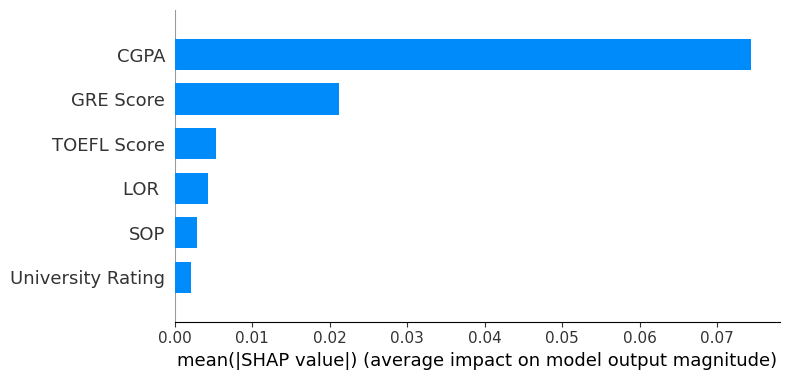

In [ ]:
shap.summary_plot(shap_values_reg, X_train, plot_type="bar")

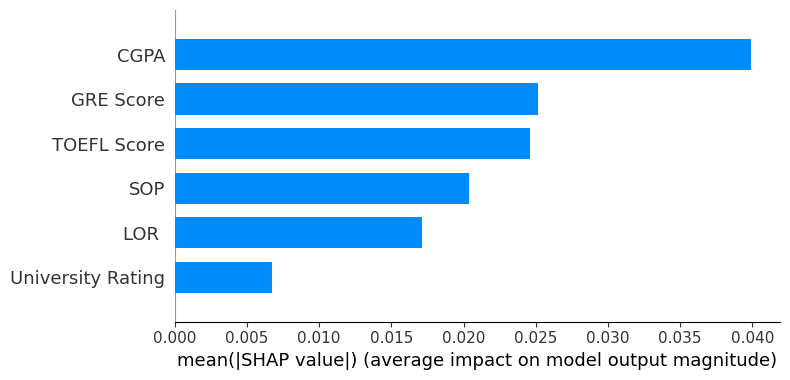

In [ ]:
shap.summary_plot(shap_values_cls[:, :, 1], X_train, plot_type="bar")

#### Beeswarm Plot

**Shows SHAP values distribution. It highlights direction and magnitude of each feature on prediction**.

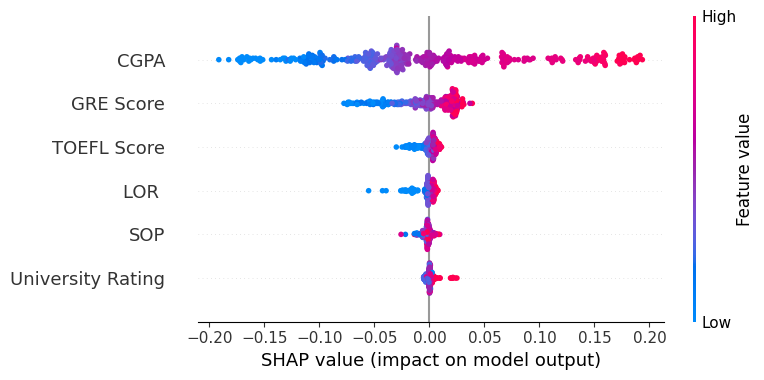

In [ ]:
shap.summary_plot(shap_values_reg, X_train, plot_type="dot")

**Red color -> high feature value**

**Blue color -> low feature value**

**SHAP value > 0 -> increases outcome**

**SHAP value < 0 -> decreases outcome**

#### Partial Dependence Plots

**Show relationship between feature and predicted outcome**

**Shows feature's impact across its range**

For each sample:
1. Vary value of selected feature
2. Hold other features constant
3. Predict outcome

**Average results from all samples**

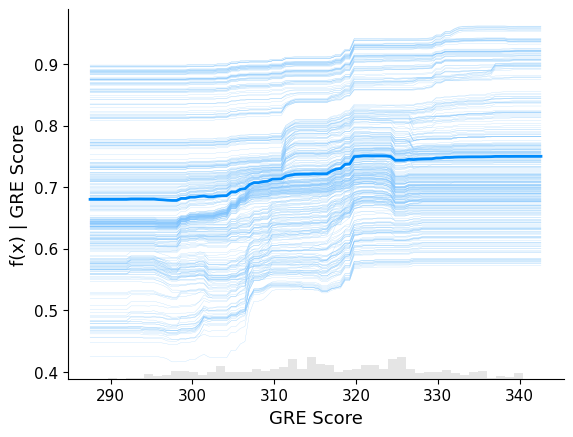

In [ ]:
shap.partial_dependence_plot("GRE Score", rf_regressor.predict, X_train)

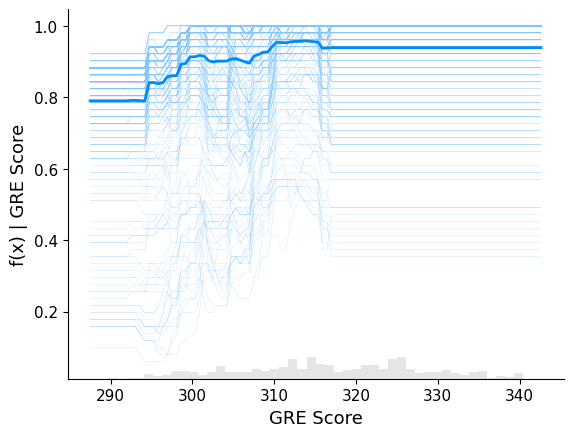

In [ ]:
shap.partial_dependence_plot("GRE Score", lambda X: rf_classifier.predict_proba(X)[:, 1], X_train)

#### Local Explainability

In [ ]:
test_instance = X_test.iloc[2, :]

In [ ]:
test_instance

GRE Score            315.00
TOEFL Score          105.00
University Rating      2.00
SOP                    2.00
LOR                    2.50
CGPA                   7.65
Name: 374, dtype: float64

In [ ]:
test_shap_values = explainer_cls.shap_values(test_instance)

In [ ]:
test_shap_values.shape

(6, 2)

#### SHAP Waterfall Plots

Shows how features increase or decrease model's prediction

In [ ]:
test_instance

GRE Score            315.00
TOEFL Score          105.00
University Rating      2.00
SOP                    2.00
LOR                    2.50
CGPA                   7.65
Name: 374, dtype: float64

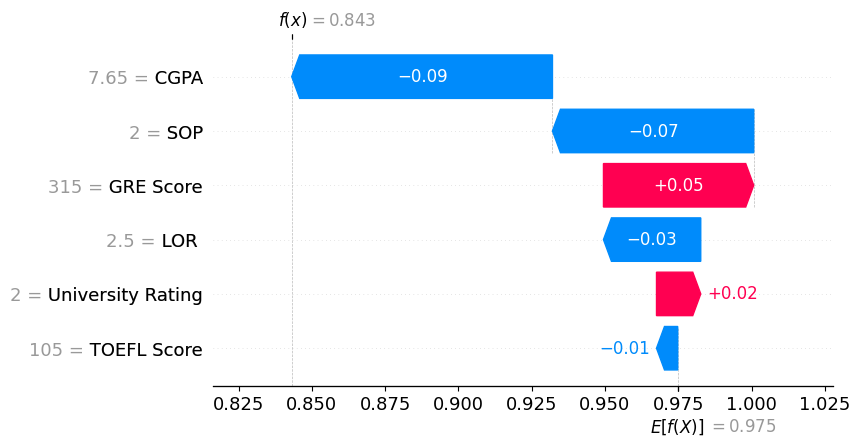

In [ ]:
shap.waterfall_plot(
    shap.Explanation(
        values=test_shap_values[:, 1],
        base_values=explainer_cls.expected_value[1],
        data=test_instance,
        feature_names=X_test.columns
    )
)

#### LIME (Local Interpretable Model-Agnostic Explanations)

Lime Explainers are:
- Tailored to different kinds of data
- Generates perturbations around a sample
- Sees effect on model's output
- Constructs simpler model for explanation

Lime has three types of explainers:
1. Tabular Explainers
2. Text Explainers
3. Image Explainers

##### Classification

In [ ]:
lime_explainer_cls = LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    mode='classification'
)

In [ ]:
explanation_cls = lime_explainer_cls.explain_instance(
    test_instance.values,
    rf_classifier.predict_proba
)

c:\Users\aleen\OneDrive\Desktop\DM_learn\DM_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


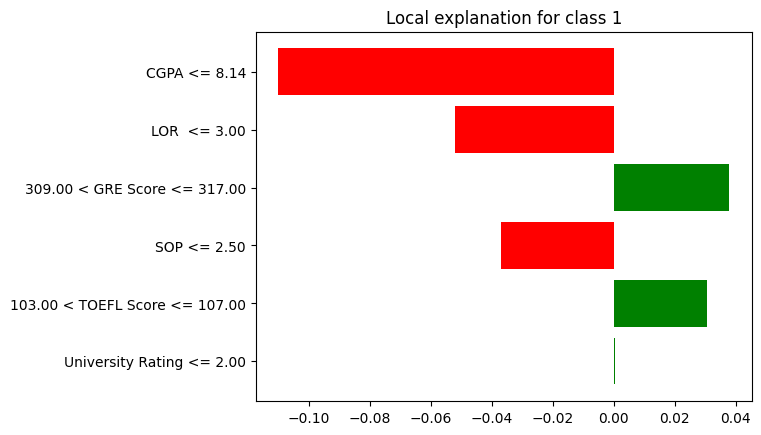

In [ ]:
explanation_cls.as_pyplot_figure();

#### SHAP and Lime Documentation

For further information on SHAP: https://shap.readthedocs.io/en/latest/index.html

For further information on Lime: 
https://lime-ml.readthedocs.io/en/latest/